In [1]:
from comibis.utils import *
from comibis.polar import *

# Import data

438 scw found
['150-200' '200-210' '210-220' '220-230' '230-240' '240-250' '250-260'
 '260-270' '270-280' '280-290' '290-300' '300-325' '325-350' '350-400'
 '400-450' '450-500' '500-600' '600-800' '800-1000']


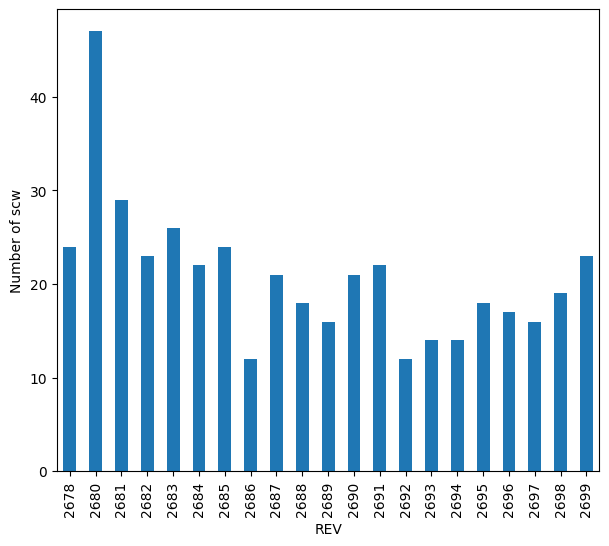

In [2]:
src = 'S1727' # short-hand name of source
scw_file_name_list = ['lowe2_newic'] # several df can be combined (energy/pola bins need to match)

plot_scw=1 # to plot the distribution of scw over time or rev
resp_dir='compton_responses'
saved_pola_folder = 'saved_pola_df'
spicorr_file = 'spicorr_2YEAR_5deg.csv' # file with the time-dependant SPI-correction factor

if plot_scw: fig, ax= plt.subplots(1,1,figsize=(7,6))
df_pola_scw, band_names = charge_df(src, scw_file_name_list,saved_pola_folder, resp_dir, spicorr_file, plot_scw)

# Show polarization parameters (PA, PF) as a function of energy 
some further selection on off-axis angle, date, revolution number, etc... can be done

111 scw selected (avg off-axis angle = 3.6°)


*** -------------------------------------------------------------------------

Polarized flux in 210-250 keV band


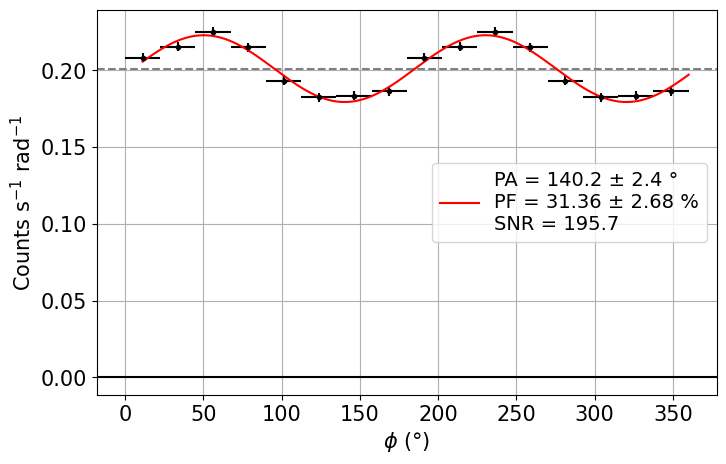

mean flux = 0.2011232781066549 ± 0.01566326621918509 ct/s/rad  a0*C=0.02176072790967322
total flux = 1.2637 ± 0.0183 ct/s
SNR = 195.7 P(no pola) = 0.00044 -> 3.5-sigma detection
PA = 140.2 ± 2.4
PF = 140.25 ± 2.44


*** -------------------------------------------------------------------------

Polarized flux in 250-300 keV band


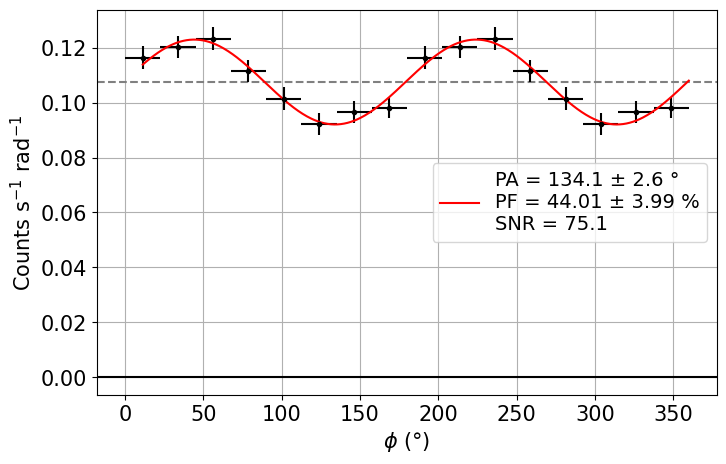

mean flux = 0.10748393104181854 ± 0.011144986745102177 ct/s/rad  a0*C=0.015450786724784286
total flux = 0.6753 ± 0.0254 ct/s
SNR = 75.1 P(no pola) = 0.00046 -> 3.5-sigma detection
PA = 134.1 ± 2.6
PF = 134.09 ± 2.58


*** -------------------------------------------------------------------------

Polarized flux in 300-400 keV band


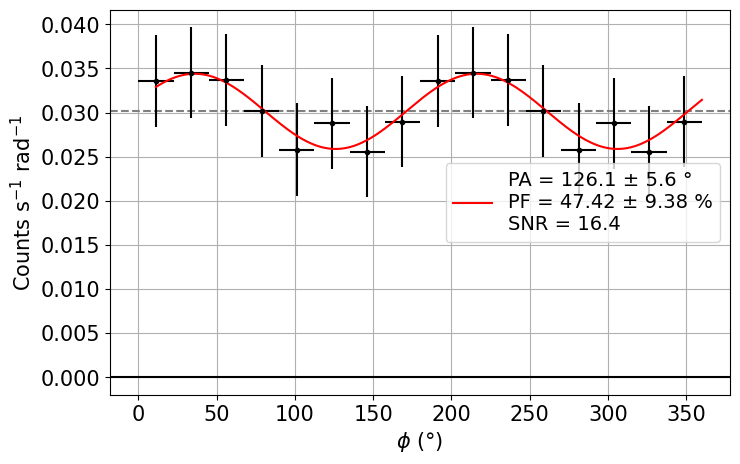

mean flux = 0.03013309747968026 ± 0.0032916640997055708 ct/s/rad  a0*C=0.00426046558330772
total flux = 0.1893 ± 0.0326 ct/s
SNR = 16.4 P(no pola) = 0.00123 -> 3.2-sigma detection
PA = 126.1 ± 5.6
PF = 126.05 ± 5.64


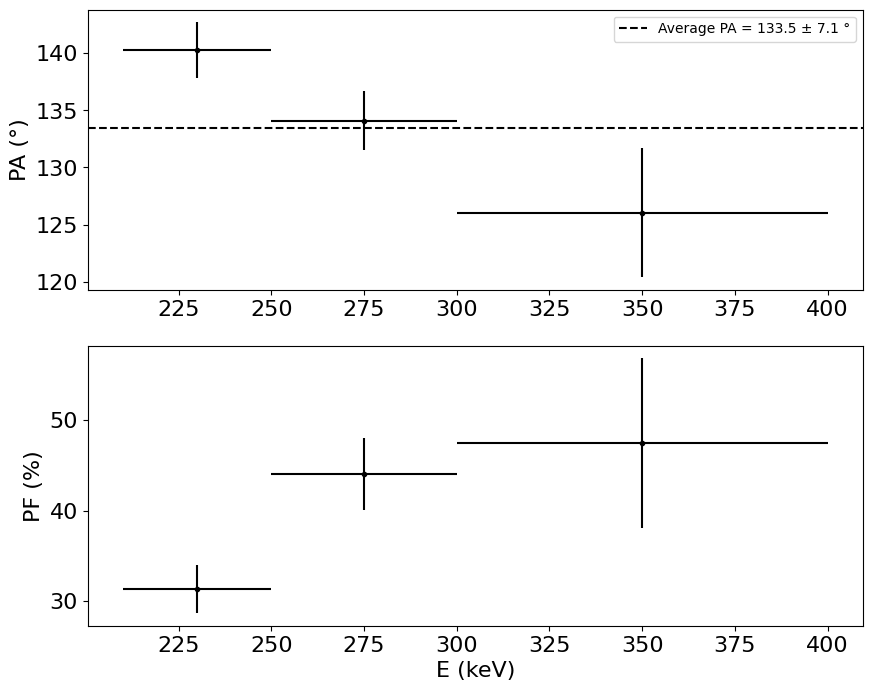

In [3]:
angle_max=5. # maximum off-axis angle
spicorr='auto'
# date_type, start_date, end_date= 'ISOT', '2018-01-01','2023-01-01' # ex using ISOT
# date_type, start_date, end_date= 'MJD', 58500, 65000 # ex using MJD
date_type, start_date, end_date= None, None, None
rev_list= ['2680','2681','2682','2683','2684'] # Hard-Intermediate State
energy_bands=['210-250','250-300','300-400'] # or 'all' to fit all energy bands

p_uplim=0.01 # polar detection threshold (1% is eq to sigma=2.5)
SNR_threshold = 12. # flux detection threshold
pa_mod= 'PA_ref90' # which angle to center PA around (90° or 0°)
plot_scale='lin' # 'log'


df_pola_scw_sel = scw_selection(df_pola_scw, angle_max=angle_max, rev_list=rev_list, start_date=start_date, end_date=end_date, date_type=date_type)
print('{0} scw selected (avg off-axis angle = {1:.1f}°)'.format(len(df_pola_scw_sel.SCW.unique()),df_pola_scw_sel.ANGLE.mean()))
all_polarigrams = Polarigram(df_pola_scw_sel, band_names, angle_max)
all_polarigrams.import_prf(pulsefrac_dir='compton_responses', pulsefrac_file='comps-prf-1.txt')
all_polarigrams.make_polar(spicorr)
all_polarigrams.pola_espectrum(energy_bands, pa_mod, SNR_threshold, p_uplim, verbose=1)
all_polarigrams.plot_polar_espectrum(plot_scale, plot_percent=True)